In [1]:
## Imports
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
from sqlalchemy import create_engine

engine = create_engine('sqlite:///data.db', echo=False)
con = engine.connect()

df_patient = pd.read_csv("australia_covid_no_dup.csv")
# + df_pcr to load
df_pcr = pd.read_sql('select * from test', con=con)
con.close()

EDA to do

Visualization

- camembert pos/neg total
- age
    - ratio pos/neg by age
    - total pos/neg by age
- state
    - same
    - and same
    - and map w/ geopandas if time allows?

In [10]:
full_df = df_patient.merge(df_pcr, on="patient_id", how="inner")

In [11]:
full_df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'patient_id', 'given_name', 'surname',
       'street_number', 'address_1', 'address_2', 'suburb', 'postcode',
       'state', 'state_corrected', 'date_of_birth', 'dob_date', 'age',
       'age_inferred', 'test_year', 'phone_number', 'phone_format',
       'phone_geo', 'all_info', 'processed', 'original', 'group', 'pcr'],
      dtype='object')

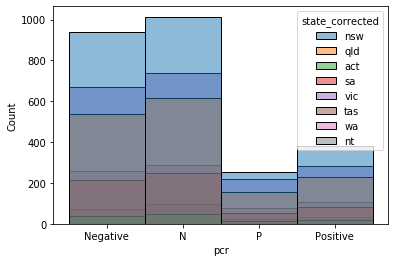

In [14]:
sns.histplot(data=full_df, x="pcr", hue="state_corrected")

In [33]:
full_df["result_pcr"] = full_df.apply(lambda row: 0 if row.pcr in ["N", "Negative"] else 1, axis=1)
full_df.groupby("state_corrected").aggregate({"result_pcr": "sum", "patient_id": "count"}).apply(lambda row: row["result_pcr"]/row["patient_id"], axis=1)

state_corrected
act    0.258621
nsw    0.244874
nt     0.098039
qld    0.250812
sa     0.222037
tas    0.262009
vic    0.262827
wa     0.253772
dtype: float64